Initial implementation of Beta-Bernoulli model, based the contig levels methylation calls. 

In [1]:
import nanomotif as nm
import polars as pl
import re
import numpy as np

# Intro

This report gives examples identifying motif in samples using the BetaBernoulli model. In this report the binary methylation representation on contig level is used, e.g. all possible methylation positions on the contig have a true or false representing methylation status at that postion.

# E.coli

E. coli is simply and have two motifs, G6mATC and C5mCWGG. 

In [2]:
assembly = nm.load_assembly("../data/ecoli/assembly.polished.fasta")
ecoli = nm.load_pileup("../data/ecoli/modkit.pileup.bed")

## 6mA

For a position to be called methylated we set a threshold of fraction of reads called as methylated at that position, here we select 80%.  Then we generate all possible motif candidates up to size 4, each motif is also represeneted with each possible methylation position withing the motif, e.g. represented as **G**ATC, G**A**TC, GA**T**C and GAT**C**. 

In [4]:
ecoli_6mA_80p = ecoli.pileup.filter(pl.col("mod_type") == "a").filter(pl.col("fraction_mod") > 0.8)

# Generate random candidates up to size 4 and modification type 6mA (a)
motif_candidates = nm.candidate.generate_random_candidates(5, "a")
scored_candidates = nm.evaluate.score_candidates(ecoli_6mA_80p, assembly["contig_3"].sequence, motif_candidates)

To evaluate the performance of the model we use the signal to noise ratio and 1 - the CDF(0.5). 

In [5]:
scored_candidates = scored_candidates.with_columns(
    pl.col("posterior").apply(lambda model: 1 - model.cdf(0.5)).alias("cdf_score"),
    pl.col("posterior").apply(lambda model: model.mean() / model.standard_deviation()).alias("signal_noise"),
).sort(pl.col("cdf_score"), descending = True)
scored_candidates

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""GATC""",1,"""a""","BetaBernoulliModel(alpha=37562, beta=688)",1.0,1445.112081
"""AGATC""",2,"""a""","BetaBernoulliModel(alpha=7712, beta=180)",1.0,581.524892
"""CGATC""",2,"""a""","BetaBernoulliModel(alpha=10676, beta=252)",1.0,680.446877
"""GATCA""",1,"""a""","BetaBernoulliModel(alpha=10913, beta=245)",1.0,705.020385
"""GATCC""",1,"""a""","BetaBernoulliModel(alpha=8100, beta=148)",1.0,671.911855
"""GATCG""",1,"""a""","BetaBernoulliModel(alpha=10767, beta=161)",1.0,854.918335
"""GATCT""",1,"""a""","BetaBernoulliModel(alpha=7768, beta=124)",1.0,703.177259
"""GGATC""",2,"""a""","BetaBernoulliModel(alpha=8136, beta=112)",1.0,774.100077
"""TGATC""",2,"""a""","BetaBernoulliModel(alpha=11026, beta=132)",1.0,965.460849


In [ ]:
scored_candidates.filter(pl.col("cdf_score") > 0.01)

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""GATC""",1,"""a""","BetaBernoulliModel(alpha=37562, beta=688)",1.0,1445.112081
"""AGATC""",2,"""a""","BetaBernoulliModel(alpha=7712, beta=180)",1.0,581.524892
"""CGATC""",2,"""a""","BetaBernoulliModel(alpha=10676, beta=252)",1.0,680.446877
"""GATCA""",1,"""a""","BetaBernoulliModel(alpha=10913, beta=245)",1.0,705.020385
"""GATCC""",1,"""a""","BetaBernoulliModel(alpha=8100, beta=148)",1.0,671.911855
"""GATCG""",1,"""a""","BetaBernoulliModel(alpha=10767, beta=161)",1.0,854.918335
"""GATCT""",1,"""a""","BetaBernoulliModel(alpha=7768, beta=124)",1.0,703.177259
"""GGATC""",2,"""a""","BetaBernoulliModel(alpha=8136, beta=112)",1.0,774.100077
"""TGATC""",2,"""a""","BetaBernoulliModel(alpha=11026, beta=132)",1.0,965.460849


GATC is easily identified here, and the 1-CDF would only select that one. 

## 5mC

We do the exact same as with 6mA, but looking at candidates up to size 5. 

In [ ]:
ecoli_5mC_80p = ecoli.pileup.filter(pl.col("mod_type") == "m").filter(pl.col("fraction_mod") > 0.8)
candidates = nm.candidate.generate_random_candidates(5, "m")
scored_candidates_5mC = nm.evaluate.score_candidates(ecoli_5mC_80p, assembly["contig_3"], candidates)

In [ ]:
scored_candidates_5mC = scored_candidates_5mC.with_columns(
    pl.col("posterior").apply(lambda model: 1 - model.cdf(0.5)).alias("cdf_score"),
    pl.col("posterior").apply(lambda model: model.mean() / model.standard_deviation()).alias("signal_noise"),
).sort(pl.col("signal_noise"), descending = True)
scored_candidates_5mC

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""CCTGG""",1,"""m""","BetaBernoulliModel(alpha=11995, beta=54)",1.0,1636.050744
"""CCAGG""",1,"""m""","BetaBernoulliModel(alpha=11959, beta=90)",1.0,1265.376316
"""G""",0,"""m""","BetaBernoulliModel(alpha=65608, beta=2291146)",0.0,259.782107
"""A""",0,"""m""","BetaBernoulliModel(alpha=62380, beta=2221038)",0.0,253.243027
"""T""",0,"""m""","BetaBernoulliModel(alpha=49992, beta=2233426)",0.0,226.077466
"""CA""",1,"""m""","BetaBernoulliModel(alpha=25655, beta=621814)",0.0,163.442722
"""C""",0,"""m""","BetaBernoulliModel(alpha=24572, beta=2332182)",0.0,157.578242
"""CC""",1,"""m""","BetaBernoulliModel(alpha=22383, beta=439228)",0.0,153.374332
"""CG""",1,"""m""","BetaBernoulliModel(alpha=22627, beta=670751)",0.0,152.938972


In [ ]:
scored_candidates_5mC.filter(pl.col("cdf_score") > 0.01)

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""CCTGG""",1,"""m""","BetaBernoulliModel(alpha=11995, beta=54)",1.0,1636.050744
"""CCAGG""",1,"""m""","BetaBernoulliModel(alpha=11959, beta=90)",1.0,1265.376316


Again we see the two expected motif clearly at the top, CCAGG and CCTGG. 

# M. ruber

## Known Methylated Motifs

6mA modified motifs informed by provider of the samples
* CTCG6mAG
* G6mATC
* A6mATT 
* TTA6mA

Additionaly, the following methylation information from [The Epigenomic Landscape of Prokaryotes](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005854#sec030), [sup 3](https://doi.org/10.1371/journal.pgen.1005854.s014) is available.

| Organism                    | ID       | 141  | Locus_Tag | Methyltransferase  | Type | Methylation | Motif      | Percent | Activity         | Notes               |
|-----------------------------|----------|------|-----------|--------------------|------|-------------|------------|---------|------------------|---------------------|
| Meiothermus ruber DSM 1279  | 646564545| 141  | Mrub_2398 | M.Mru1279V         | II   | m4C         | rGatCy     | 92.1    | active           | Mru1279VP           |
|                             |          |      | Mrub_2385 | M.Mru1279II        | II   | m6A         | **cTcgAg**     | 99.5    | active           |                     |
|                             |          |      | Mrub_1464 | M.Mru1279VII       | II   | m6A         | **gATc**       | 80.7    | active           |                     |
|                             |          |      | Mrub_1513 | M.Mru1279VI        | II   | m6A         | **TtaA**       | 99.9    | active           |                     |
|                             |          |      | Mrub_2453 | M.Mru1279I         | I    | m6A         | **ggcAnnnnnnTgg** | 99.8  | active           | S.Mru1279I,Mru1279IP |
|                             |          |      | Mrub_0831 | M.Mru1279III       | II   | m6A         | **aATt**       | 99      | active           |                     |
|                             |          |      | Mrub_2576 | M.Mru1279IV        | II   | m4C         | caGCtg     | 98.5    | active           |                     |
|                             |          |      | Mrub_2712 | M.Mru1279ORF2712P  | II   | m5C         | GGWCC      | N/A     | Not Detected     | Mru1279ORF2712P     |
|                             |          |      | Mrub_1239 | Mru1279ORF1239P    | IIG* | m6A         | (Unknown)  | N/A     | possibly active  |                     |
|                             |          |      | Mrub_0580 | M.Mru1279ORF580P   | III  | m6A         | (Unknown)  | N/A     | possibly active  | Mru1279ORF580P      |
|                             |          |      | Mrub_0441 | Mru1279ORF441P     | IIG* | m6A         | (Unknown)  | N/A     | possibly active  |                     |




In [ ]:
mruber_assembly = nm.load_assembly("../data/mruber/assembly.polished.fasta")
mruber_pileup = nm.load_pileup("../data/mruber/modkit.pileup.bed")

In [ ]:
mruber_pileup_6mA_80 = mruber_pileup.pileup.filter(pl.col("mod_type") == "a").filter(pl.col("fraction_mod") > 0.7)
candidates = nm.candidate.generate_random_candidates(4, "a")
candidates.add_candidates(["CTCGAG"], [4], ["a"])
candidates.add_candidates(["GGCA" + "[ATGC]"*6 + "TGG"], [3], ["a"])

In [ ]:
scored_candidates_6mA = nm.evaluate.score_candidates(mruber_pileup_6mA_80, mruber_assembly["contig_1"], candidates)

In [ ]:
scored_candidates_6mA = scored_candidates_6mA.with_columns(
    pl.col("posterior").apply(lambda model: 1 - model.cdf(0.5)).alias("cdf_score"),
    pl.col("posterior").apply(lambda model: model.mean() / model.standard_deviation()).alias("signal_noise"),
).sort(pl.col("signal_noise"), descending = True)
scored_candidates_6mA

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""CTCGAG""",4,"""a""","BetaBernoulliModel(alpha=14416, beta=650)",1.0,578.068231
"""AATT""",1,"""a""","BetaBernoulliModel(alpha=6044, beta=138)",1.0,520.38205
"""C""",0,"""a""","BetaBernoulliModel(alpha=193560, beta=1769685)",0.0,463.39056
"""G""",0,"""a""","BetaBernoulliModel(alpha=184361, beta=1778884)",0.0,451.07429
"""T""",0,"""a""","BetaBernoulliModel(alpha=108905, beta=1025321)",0.0,347.091497
"""TTAA""",3,"""a""","BetaBernoulliModel(alpha=4447, beta=193)",1.0,327.009745
"""CC""",1,"""a""","BetaBernoulliModel(alpha=69486, beta=451957)",0.0,283.141765
"""GATC""",1,"""a""","BetaBernoulliModel(alpha=15166, beta=4254)",1.0,263.13134
"""GG""",0,"""a""","BetaBernoulliModel(alpha=59134, beta=462309)",0.0,258.259492


In [ ]:
scored_candidates_6mA.filter(pl.col("cdf_score") > 0.5)

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""CTCGAG""",4,"""a""","BetaBernoulliModel(alpha=14416, beta=650)",1.0,578.068231
"""AATT""",1,"""a""","BetaBernoulliModel(alpha=6044, beta=138)",1.0,520.38205
"""TTAA""",3,"""a""","BetaBernoulliModel(alpha=4447, beta=193)",1.0,327.009745
"""GATC""",1,"""a""","BetaBernoulliModel(alpha=15166, beta=4254)",1.0,263.13134
"""GGCA[ATGC][ATG…",3,"""a""","BetaBernoulliModel(alpha=747, beta=492)",1.0,43.389894


In [ ]:
ax = scored_candidates_6mA.filter(pl.col("motif") == "GGCA" + "."*6 + "TGG") \
    .get_column("posterior")[0].plot();
ax.set_title("GGCANNNNNNTGG Beta distrubution");

ComputeError: index is out of bounds

The expected candidates nicely show up. 

## Smaller contigs

Lets simulate having more contigs. But still the some coverage.

In [ ]:
# Original contig
parent_contig = mruber_assembly["contig_1"]

# Size of subcontigs
contigs_size = 50000

n_child_contigs = len(parent_contig) // contigs_size + 1
sim_contig_scores = []
for i in range(n_child_contigs - 1):
    sub_contig = parent_contig[i*contigs_size : min(((i+1)*contigs_size - 1), len(parent_contig)-1)]
    # Substract index of subcontig start to methylation positions, to make sure motif index match
    temp_pileup = mruber_pileup_6mA_80.with_columns(
        pl.col("position") - i*contigs_size
    )
    sim_contig_scores.append(nm.evaluate.score_candidates(temp_pileup, sub_contig, candidates))
    

In [ ]:
result = []
for i, contig_candidates in enumerate(sim_contig_scores):
    result.append(
        contig_candidates.with_columns(
            pl.col("posterior").apply(lambda model: 1 - model.cdf(0.55)).alias("cdf_score"),
            pl.col("posterior").apply(lambda model: model.mean() / model.standard_deviation()).alias("signal_noise")
        ).sort(pl.col("signal_noise"), descending = True) \
        .filter(pl.col("cdf_score") > 0.1) \
        .with_columns(
            pl.lit(i).alias("sub_index")
        )    
    )
result = pl.concat(result)

/shared_software/podman/tmp/lx38ll@bio.aau.dk/ipykernel_1281937/434150598.py:6: DeprecationWarning: In a future version of polars, the default `aggregate_function` will change from `'first'` to `None`. Please pass `'first'` to keep the current behaviour, or `None` to accept the new one.
  result.with_columns(


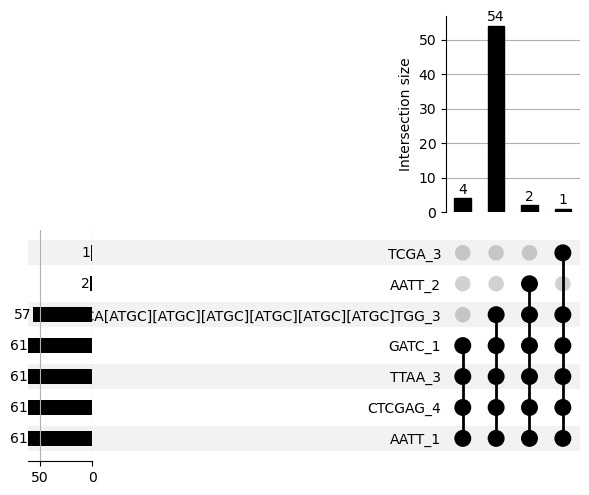

In [ ]:
from upsetplot import UpSet
all_motifs = result.with_columns(
        pl.col("motif") + "_" + pl.col("motif_meth_index").cast(pl.Utf8)
        ).get_column("motif").unique().to_list()
UpSet(
    result.with_columns(
        pl.col("motif") + "_" + pl.col("motif_meth_index").cast(pl.Utf8),
        pl.lit(True).alias("val")
        ) \
    .pivot(values = "val", index = "sub_index", columns = "motif") \
    .fill_null(False).to_pandas().set_index(all_motifs),
    show_counts = True
)

# Geobacillus



In [ ]:
geo_assembly = nm.load_assembly("../data/geobacillus/assembly.polished.fasta")
geo_pileup = nm.load_pileup("../data/geobacillus/modkit.pileup.bed")
geo_6ma_80p = geo_pileup.pileup.filter(pl.col("mod_type") == "a").filter(pl.col("fraction_mod") > 0.8)
motif_candidates = nm.candidate.generate_random_candidates(5, "a")
scored_candidates = nm.evaluate.score_candidates(geo_6ma_80p, geo_assembly["contig_3"], motif_candidates)

In [ ]:
scored_candidates.with_columns(
    pl.col("posterior").apply(lambda model: 1 - model.cdf(0.5)).alias("cdf_score"),
    pl.col("posterior").apply(lambda model: model.mean() / model.standard_deviation()).alias("signal_noise"),
).sort(pl.col("cdf_score"), descending = True).filter(pl.col("cdf_score") > 0.1)

motif,motif_meth_index,mod_type,posterior,cdf_score,signal_noise
str,i64,str,object,f64,f64
"""GATC""",1,"""a""","BetaBernoulliModel(alpha=610, beta=100)",1.0,65.856663
"""CGATC""",2,"""a""","BetaBernoulliModel(alpha=204, beta=24)",1.0,44.119157
"""GATCA""",1,"""a""","BetaBernoulliModel(alpha=183, beta=37)",1.0,33.061368
"""GATCC""",1,"""a""","BetaBernoulliModel(alpha=125, beta=20)",1.0,30.207615
"""GATCG""",1,"""a""","BetaBernoulliModel(alpha=208, beta=20)",1.0,48.801639
"""GGATC""",2,"""a""","BetaBernoulliModel(alpha=127, beta=18)",1.0,32.095344
"""TGATC""",2,"""a""","BetaBernoulliModel(alpha=195, beta=25)",1.0,41.51867
"""GATCT""",1,"""a""","BetaBernoulliModel(alpha=96, beta=26)",1.0,21.310886
"""AGATC""",2,"""a""","BetaBernoulliModel(alpha=87, beta=35)",0.999999,17.485504


In [ ]:
def remove_super_members(lst):
    # A set to store the strings to be removed
    to_remove = set()

    # Compare each string against all other strings
    for i, string1 in enumerate(lst):
        for j, string2 in enumerate(lst):
            # If s1 is a substring of s2 and they're not the same string
            if string1 in string2 and i != j:
                to_remove.add(string2)

    # Use a list comprehension to create a new list excluding the super members
    result = [s for s in lst if s not in to_remove]

    return result


['C', 'G', 'T', 'A']